

<figure>
   <IMG SRC="https://avatars2.githubusercontent.com/u/31697400?s=400&u=a5a6fc31ec93c07853dd53835936fd90c44f7483&v=4" WIDTH=125 ALIGN="right">
</figure>
    
# Local grid refinement   

This notebook shows an example of an unstructured model create with the `nlmod` package.

### Table of contents
1. [Create model](#create)
2. [Run model](#run)
3. [Visualise](#Visualise)

In [1]:
import matplotlib.pyplot as plt
import flopy
import os
import geopandas as gpd

import nlmod

print(f'nlmod version: {nlmod.__version__}')

nlmod version: 0.0.2b


### 1. Create model<a name="create"></a>

Modflow 6 makes it possible to use locally refined grids. In NLmod you can use a shapefile and a number of levels to specify where and how much you want to use local grid refinement. Below we use a shapefile of the Planetenweg in IJmuiden and set the refinement levels at 2. This well create a grid with cells of 100x100m except at the Planetenweg where the cells will be refined to 25x25m. See also figures below.

Note: the `gen_model_unstructured` function also returns the `gridprops` dictionary. This contains data that is necesary to create some packages. It can be time consuming to generate this data.

In [2]:
# model settings unstructured
model_ws = 'model2'
model_name = 'IJm_planeten'
refine_shp_fname = os.path.join(
    nlmod.nlmod_datadir, 'shapes', 'planetenweg_ijmuiden')
levels = 2
use_cache = False
extent = [95000., 105000., 494000., 500000.]
delr = 100.
delc = 100.
steady_state = False
steady_start = True
transient_timesteps = 5
perlen = 1.
verbose = True
start_time = '2015-1-1'
gridtype = 'unstructured'
use_regis = True
regis_botm_layer = b'MSz1'
use_geotop = True
add_northsea = True
starting_head = 1.0

In [3]:
# Model directories
figdir, cachedir, gridgen_ws = nlmod.util.get_model_dirs(
    model_ws, gridtype=gridtype)


# create model time dataset
model_ds = nlmod.mdims.get_model_ds_time(model_name, model_ws, start_time,
                                         steady_state, steady_start=steady_start,
                                         transient_timesteps=transient_timesteps,
                                         perlen=perlen)

# create modflow packages
sim, gwf = nlmod.mfpackages.sim_tdis_gwf_ims_from_model_ds(model_ds,
                                                           verbose=verbose)

extent, nrow, ncol = nlmod.read.regis.fit_extent_to_regis(extent,
                                                          delr,
                                                          delc, verbose=verbose)

# layer model
layer_model = nlmod.read.regis.get_layer_models(extent, delr, delc,
                                                use_regis=use_regis,
                                                regis_botm_layer=regis_botm_layer,
                                                use_geotop=use_geotop,
                                                cachedir=cachedir,
                                                fname_netcdf='combined_layer_ds.nc',
                                                use_cache=use_cache,
                                                verbose=verbose)

creating modflow SIM, TDIS, GWF and IMS
redefining current extent: [95000.0, 105000.0, 494000.0, 500000.0], fit to regis raster
new extent is [95000.0, 105000.0, 494000.0, 500000.0] model has 60 rows and 100 columns
creating and caching dataset combined_layer_ds.nc



### Local grid refinement

the code below applies a local grid refinement to the layer model. The local grid refinement is based on the shapefile 'planetenweg_ijmuiden.shp', which contains a line shape of the Planetenweg, and the levels, which is 2. This means that the model cells at the Planetenweg will get a size of 25 x 25m. 

In [4]:
# use gridgen to create unstructured grid
gridprops = nlmod.mdims.create_unstructured_grid(gridgen_ws, model_name, gwf,
                                                 [(refine_shp_fname, 'line', levels)],
                                                 extent,
                                                 layer_model.dims['layer'],
                                                 nrow, ncol,
                                                 delr, delc,
                                                 cachedir=cachedir, use_cache=use_cache,
                                                 verbose=verbose)

# add layer model to unstructured grid
layer_model_unstr = nlmod.mdims.get_ml_layer_dataset_unstruc(raw_ds=layer_model,
                                                             extent=extent,
                                                             gridprops=gridprops,
                                                             cachedir=cachedir,
                                                             fname_netcdf='layer_model_unstr.nc',
                                                             use_cache=use_cache,
                                                             verbose=verbose)

# combine model time dataset with layer model dataset
model_ds = nlmod.mdims.update_model_ds_from_ml_layer_ds(model_ds,
                                                        layer_model_unstr,
                                                        gridtype,
                                                        keep_vars=['x', 'y'],
                                                        gridprops=gridprops,
                                                        add_northsea=add_northsea,
                                                        verbose=verbose)

# Create discretization
disv = nlmod.mfpackages.disv_from_model_ds(model_ds, gwf, gridprops)

create unstructured grid using gridgen
write cache for griddata data to model2/cache/gridprops.pklz
creating and caching dataset layer_model_unstr.nc

add kh and kv from model layer dataset to modflow model
layer 0 has a kh
layer 1 has a kh
layer 2 has a kh
layer 3 has a kh
layer 4 has a kh
layer 5 has a kh
layer 6 has a kh
layer 7 has a kh
layer 8 has a kh
layer 9 has a kh
layer 10 has a kh
layer 11 has a kh
layer 12 has a kh
layer 13 has a kh
layer 14 has a kv
layer 15 has a kh
layer 16 has a kv
layer 17 has a kh
layer 18 has a kh
layer 19 has a kv
layer 20 has a kh
layer 21 has a kv
layer 22 has a kh
layer 23 has a kh
layer 24 has a kh
layer 25 has a kh
layer 26 has a kv
layer 27 has a kh
layer 28 has a kh
layer 29 has a kv
layer 30 has a kh
layer 31 has a kh
layer 32 has a kh
layer 33 has a kv
layer 34 has a kh
layer 35 has a kv
layer 36 has a kh
layer 37 has a kh
layer 38 has a kh
layer 39 has a kh
layer 0 has a kv
layer 1 has a kv
layer 2 has a kv
layer 3 has a kv
layer 4 has a k

In [5]:
# create node property flow
nlmod.mfpackages.npf_from_model_ds(model_ds, gwf)

# Create the initial conditions package
nlmod.mfpackages.ic_from_model_ds(model_ds, gwf, starting_head=starting_head)

# Create the output control package
oc = nlmod.mfpackages.oc_from_model_ds(model_ds, gwf)

In [6]:
# voeg grote oppervlaktewaterlichamen toe
da_name = 'surface_water'
model_ds = nlmod.mfpackages.surface_water.get_general_head_boundary(model_ds,
                                                                    gwf.modelgrid,
                                                                    da_name,
                                                                    cachedir=cachedir,
                                                                    use_cache=use_cache,
                                                                    verbose=verbose)
ghb = nlmod.mfpackages.ghb_from_model_ds(model_ds, gwf, da_name)

# surface level drain
model_ds = nlmod.read.ahn.get_ahn_dataset(model_ds, gridprops=gridprops,
                                          use_cache=use_cache,
                                          cachedir=cachedir, verbose=verbose)

drn = nlmod.mfpackages.surface_drain_from_model_ds(model_ds, gwf)


# add constant head cells at model boundaries
chd = nlmod.mfpackages.chd_at_model_edge_from_model_ds(
    model_ds, gwf, head='starting_head')

creating and caching dataset ghb_model_ds.nc

creating and caching dataset ahn_model_ds.nc

requested ahn raster width or height bigger than 4000.0
            -> splitting extent into 3 * 2 tiles
downloading subextent [95000.0, 99000.0, 494000.0, 498000.0]
x_segment-0, y_segment-0
- download model2/cache/ahn_95000_99000_494000_498000_5000.tiff
downloading subextent [95000.0, 99000.0, 498000.0, 500000.0]
x_segment-0, y_segment-1
- download model2/cache/ahn_95000_99000_498000_500000_5000.tiff
downloading subextent [99000.0, 103000.0, 494000.0, 498000.0]
x_segment-1, y_segment-0
- download model2/cache/ahn_99000_103000_494000_498000_5000.tiff
downloading subextent [99000.0, 103000.0, 498000.0, 500000.0]
x_segment-1, y_segment-1
- download model2/cache/ahn_99000_103000_498000_500000_5000.tiff
downloading subextent [103000.0, 105000.0, 494000.0, 498000.0]
x_segment-2, y_segment-0
- download model2/cache/ahn_103000_105000_494000_498000_5000.tiff
downloading subextent [103000.0, 105000.0, 49

In [7]:
# add knmi recharge to the model datasets
model_ds = nlmod.read.knmi.get_recharge(model_ds,
                                        verbose=verbose,
                                        cachedir=cachedir,
                                        use_cache=use_cache)
# create recharge package
rch = nlmod.mfpackages.rch_from_model_ds(model_ds, gwf)

creating and caching dataset rch_model_ds.nc



Building ts packages rch: 100%|██████████| 4/4 [00:00<00:00, 76.26it/s]


In [8]:
# save model_ds
model_ds.to_netcdf(os.path.join(cachedir, 'full_model_ds.nc'))

### 2. Run<a name="run"></a>
The model that we've created has not been runned yet. When you want to save and run the model you can use the code below.

Note: You always have to write the modflow data to the model workspace before you can run the model. 

In [9]:
gwf.simulation.write_simulation()
gwf.simulation.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model IJm_planeten...
    writing model name file...
    writing package disv...
    writing package npf...
    writing package ic...
    writing package oc...
    writing package ghb_0...
    writing package drn_0...
    writing package chd...
    writing package rch...
    writing package ts_0...
    writing package ts_1...
    writing package ts_2...
    writing package ts_3...
FloPy is using the following  executable to run the model: /home/david/Github/nlmod/nlmod/mfpackages/../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

   MODFLOW 6 compiled Feb 18 2021 20:22:48 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to 

(True, [])

### 3. Visualise<a name="visualise"></a>

Using the `model_ds` and `gwf` variables it is quite easy to visualise model data. Below the modelgrid together with the surface water is shown.

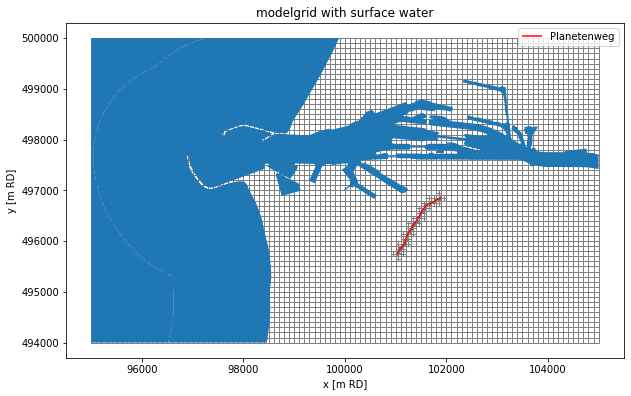

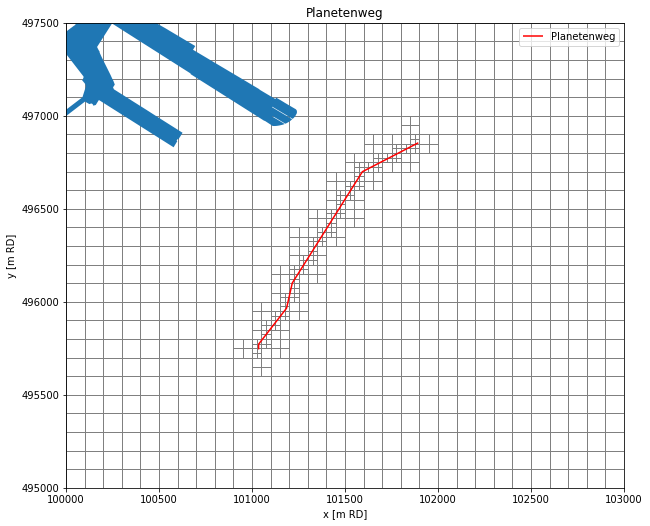

In [10]:
plan_weg_gdf = gpd.read_file(refine_shp_fname+'.shp')

# plot modelgrid
ax = nlmod.plots.plot_modelgrid(model_ds, gwf)
plan_weg_gdf.plot(ax=ax, color='r', label='Planetenweg')
ax.legend()
ax.get_figure().savefig(os.path.join(figdir, 'mgrid_swater.png'), bbox_inches='tight')

# plot zoomed modelgrid
ax = nlmod.plots.plot_modelgrid(model_ds, gwf)
ax.set_title('Planetenweg')
plan_weg_gdf.plot(ax=ax, color='r', label='Planetenweg')
ax.set_xlim(100000, 103000)
ax.set_ylim(495000, 497500)
ax.legend()
ax.get_figure().savefig(os.path.join(figdir, 'Planetenweg.png'), bbox_inches='tight')

The model dataset of an unstructured model differs from a structured model dataset. The data is stored relative to the cell-id instead of the row and column number. Therefore the model dataset has the dimension cid instead of the dimensions x and y. 

In [11]:
model_ds

<xarray.Dataset>
Dimensions:             (cid: 6231, layer: 40, time: 6)
Coordinates:
  * time                (time) datetime64[ns] 2005-01-03 ... 2015-01-05
  * cid                 (cid) int64 0 1 2 3 4 5 ... 6226 6227 6228 6229 6230
  * layer               (layer) object 'AAOP' 'NASC' 'ONAWA' ... 'PZWAz4' 'MSz1'
Data variables: (12/21)
    time_steps          (time) int64 0 1 2 3 4 5
    x                   (cid) float64 9.505e+04 9.515e+04 ... 1.048e+05 1.05e+05
    y                   (cid) float64 5e+05 5e+05 5e+05 ... 4.940e+05 4.940e+05
    idomain             (layer, cid) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    first_active_layer  (cid) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    bot                 (layer, cid) float64 -12.66 -12.66 ... -218.2 -218.5
    ...                  ...
    surface_water_cond  (cid) float64 1e+03 1e+03 1e+03 1e+03 ... 0.0 0.0 0.0
    surface_water_peil  (cid) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ahn                 (cid) float64 nan nan nan nan ... 1.905 nan 0.782 0.277
    chd                 (layer, cid) int64 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    recharge            (cid, time) float64 0.0006817 -0.0004 ... 0.0004 -0.0004
    rch_name            (cid) <U13 'rch_1' 'rch_1' 'rch_1' ... 'rch_2' 'rch_2'
Attributes: (12/20)
    model_name:        IJm_planeten
    model_ws:          model2
    time_units:        DAYS
    start_time:        2005-01-03 00:00:00
    nper:              6
    perlen:            1.0
    ...                ...
    extent:            [95000.0, 105000.0, 494000.0, 500000.0]
    nodata:            -999
    anisotropy:        10
    fill_value_kh:     1.0
    fill_value_kv:     0.1
    surface_drn_cond:  1000

To plot the same rasters as for the previous model we can use the `nlmod.plots.plot_array()` function.

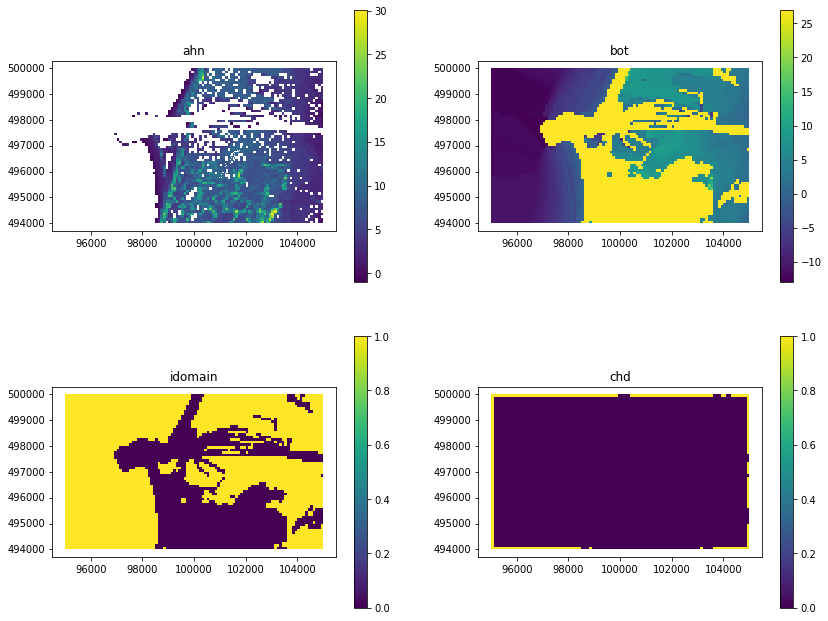

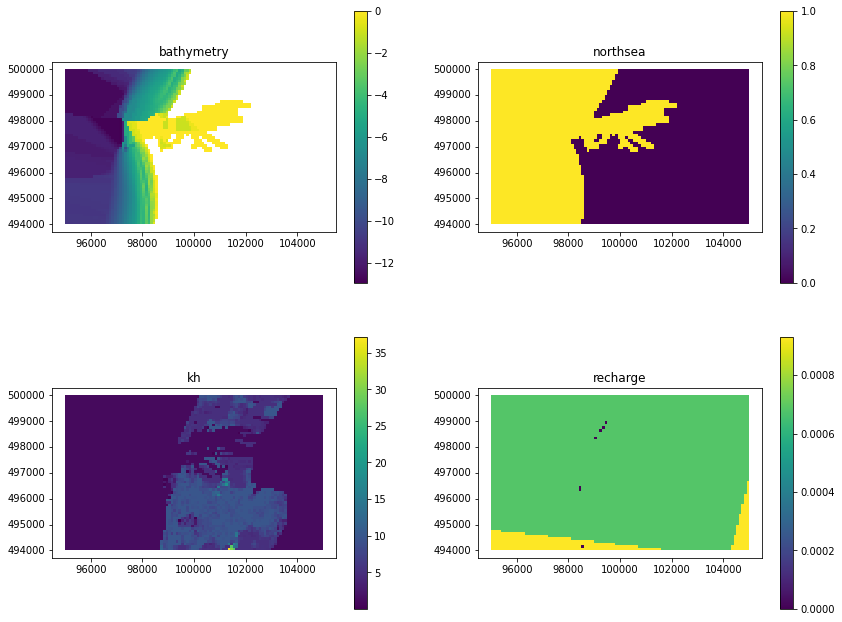

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
nlmod.plots.plot_array(gwf, model_ds['ahn'], ax=axes[0][0])
nlmod.plots.plot_array(gwf, model_ds['bot'][0], ax=axes[0][1])
nlmod.plots.plot_array(gwf, model_ds['idomain'][0], ax=axes[1][0])
nlmod.plots.plot_array(gwf, model_ds['chd'][0], ax=axes[1][1])
for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')

fig.savefig(os.path.join(figdir, 'ahn_bot_idom_chd.png'), bbox_inches='tight')

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 11))
nlmod.plots.plot_array(gwf, model_ds['bathymetry'], ax=axes[0][0])
nlmod.plots.plot_array(gwf, model_ds['northsea'], ax=axes[0][1])
nlmod.plots.plot_array(gwf, model_ds['kh'][1], ax=axes[1][0])
nlmod.plots.plot_array(gwf, model_ds['recharge'][:, 0], ax=axes[1][1])

for axes1 in axes:
    for ax in axes1:
        ax.axis('scaled')
fig.savefig(os.path.join(figdir, 'bath_nsea_kh_rch.png'), bbox_inches='tight')